In [ ]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)

In [ ]:
import os

import kfp
from kfp.dsl import (
    Input,
    Output, 
    Dataset,
    component,
    Model,
    Artifact,
    ClassificationMetrics,
)

artifacts_uri = '../artifacts/'
if not os.path.exists(artifacts_uri):
    os.makedirs(artifacts_uri)

# Training

In this notebook, we will write the code to train a model that **predicts the bike availability at a specific station at a specific point in time**. We will use **regression trees**, as some of our time variables could be treated both as numerical or categorical (ordinal). For example, day of the month or day of the week. Our expectation would be to treat them as numerical but use trees so that bins of the variables are created during the training. Example:

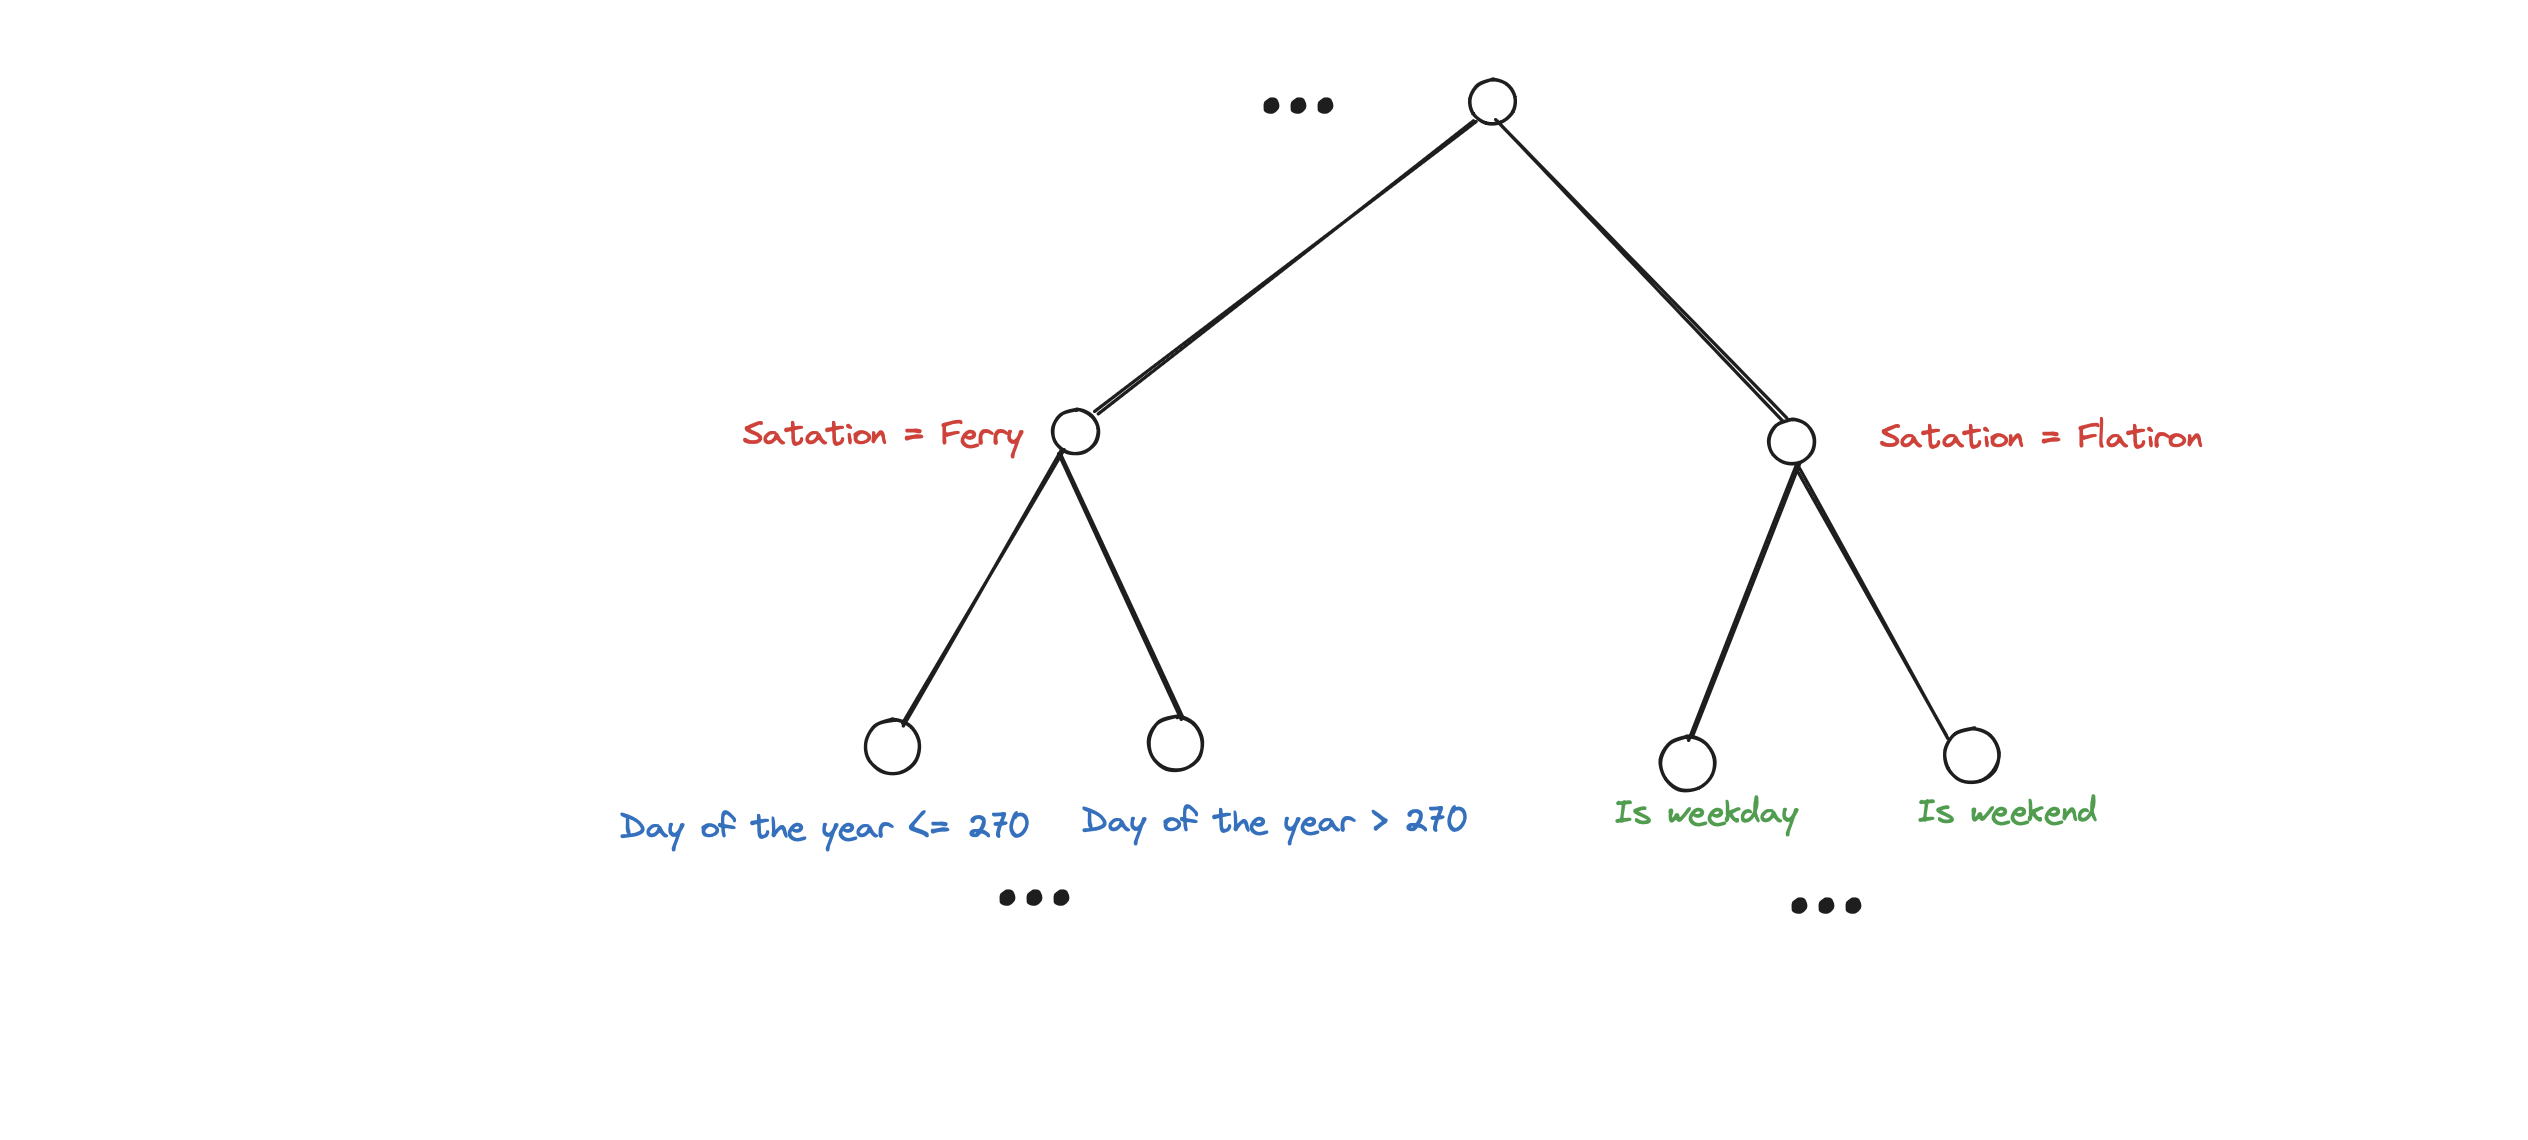

We can observe how for each station we would have different branches. For the most touristic station (Ferry) day of the year could be binned and we would have branched to take "Spring"/"Summer" together, and "Fall"/"Winter" together. And for the working station (Flatiron) the "is weekend" variable could be the one with more information gain (all of these a hypotheses, we plan to confirm when training).

So, let's go ahead with our training. As for us, understandability is currently important, we will stick to using simple Decision Trees. In the functions you will find we're using something called "Artifacts", artifacts are ways for passing datasets/models/evaluation information when working with Kubernetes, we are doing this to follow best practices and prepare for the future operationalization of this code. For more information, read [Kubeflow Artifacts Docs](https://www.kubeflow.org/docs/components/pipelines/v2/data-types/artifacts/).

In [ ]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import geopandas as gpd
manhattan = gpd.read_file('../images/manhattan_map/geo_export_f21dfb5a-3953-4e56-877a-4a3abd9673f4.shp')

import joblib
import pickle

from sklearn.tree import export_text

In [ ]:
art_df = Dataset(uri = '../data/data_prep')
df = pd.read_pickle(art_df.uri+'.pkl')
df.head()

,station_id,lat,lon,true_bike_capacity,capacity,percentage_bikes_available,dayofweek,weekend,dayofmonth,dayofyear,month,year,hour,minute,is_holiday
station_status_last_reported,,,,,,,,,,,,,,,
2020-11-30 20:55:00-05:00,259,40.701221,-74.012342,39,39,0.948718,0,0,30,335,11,2020,20,55,0
2020-11-30 21:00:00-05:00,259,40.701221,-74.012342,39,39,0.948718,0,0,30,335,11,2020,21,0,0
2020-11-30 21:05:00-05:00,259,40.701221,-74.012342,39,39,0.948718,0,0,30,335,11,2020,21,5,0
2020-11-30 21:10:00-05:00,259,40.701221,-74.012342,39,39,0.948718,0,0,30,335,11,2020,21,10,0
2020-11-30 21:15:00-05:00,259,40.701221,-74.012342,39,39,0.948718,0,0,30,335,11,2020,21,15,0


## SPLIT DATA

In [ ]:
@component(
    base_image="gcr.io/deeplearning-platform-release/base-cpu.py310:latest", # The docker image this could would need to run as a container.
)
def split_data(
    in_df: Input[Dataset],
    out_df_test: Output[Dataset],
    out_df_full_train: Output[Dataset], 
    out_df_val: Output[Dataset],
    out_df_train: Output[Dataset], 
):
    import pandas as pd

    df = pd.read_pickle(in_df.uri + ".pkl") 
    
    # We have 12 months, we'll take 8 months training,
    # 2 months for validation and 2 months for testing:
    split_date_test = pd.to_datetime("2021-10-01", utc=True).tz_convert("US/Eastern")
    split_date_val = pd.to_datetime("2021-08-01", utc=True).tz_convert("US/Eastern")
    # Filter the DataFrame for dates within the specified range
    df_test = df[df.index >= split_date_test]
    df_full_train = df[df.index < split_date_test]
    df_val = df[df.index >= split_date_val]
    df_train = df[df.index < split_date_val]

    pd.to_pickle(df_test, out_df_test.uri + ".pkl")
    pd.to_pickle(df_full_train, out_df_full_train.uri + ".pkl")
    pd.to_pickle(df_val, out_df_val.uri + ".pkl")
    pd.to_pickle(df_train, out_df_train.uri + ".pkl")

split_data_func = split_data.python_func

In [ ]:
# Artifacts to store our passing datasets (you will see right now they're stored locally,
# but in future stages of the project, this would be stores automatically on the cloud by
# services like Kubeflow)
art_df_train_full = Dataset(uri = artifacts_uri +'df_train_full')
art_df_train = Dataset(uri = artifacts_uri +'df_train')
art_df_test = Dataset(uri = artifacts_uri +'df_test')
art_df_val = Dataset(uri = artifacts_uri +'df_val')

split_data_func(
    in_df = art_df,
    out_df_full_train = art_df_train_full, 
    out_df_test = art_df_test,
    out_df_train = art_df_train, 
    out_df_val = art_df_val,
)

In [ ]:
df_train = pd.read_pickle(art_df_train.uri+'.pkl')
df_train.head()

,station_id,lat,lon,true_bike_capacity,capacity,percentage_bikes_available,dayofweek,weekend,dayofmonth,dayofyear,month,year,hour,minute,is_holiday
station_status_last_reported,,,,,,,,,,,,,,,
2020-11-30 20:55:00-05:00,259,40.701221,-74.012342,39,39,0.948718,0,0,30,335,11,2020,20,55,0
2020-11-30 21:00:00-05:00,259,40.701221,-74.012342,39,39,0.948718,0,0,30,335,11,2020,21,0,0
2020-11-30 21:05:00-05:00,259,40.701221,-74.012342,39,39,0.948718,0,0,30,335,11,2020,21,5,0
2020-11-30 21:10:00-05:00,259,40.701221,-74.012342,39,39,0.948718,0,0,30,335,11,2020,21,10,0
2020-11-30 21:15:00-05:00,259,40.701221,-74.012342,39,39,0.948718,0,0,30,335,11,2020,21,15,0


## TRAIN: DECISION TREE

In [ ]:
stations = pd.read_pickle('../data/stations.pkl') 
stations_list = stations.station_id.unique().tolist()
print(stations_list)

['259', '303', '3069', '3113', '3357', '3564', '3690', '3726', '3771', '385', '466']


In [ ]:
@component(
    base_image="gcr.io/deeplearning-platform-release/base-cpu.py310:latest",
    packages_to_install = ["scikit-learn==1.3.1"],
)
def tree_prep_train(
    in_df_train: Input[Dataset],
    label: str,
    out_dt: Output[Model],
    max_depth: int = None,
    min_samples_leaf: int = 1,
    mult_stations: bool = True,
    stations: list = [],
    pick_features: list = None,
):
    import pandas as pd 
    import numpy as np

    import joblib
    import pickle

    from sklearn.tree import DecisionTreeRegressor

    # 1. Read data:
    df_train = pd.read_pickle(in_df_train.uri + ".pkl") 

    y_train = df_train[label].copy()
    x_train = df_train.drop([label], axis=1)

    # 2. Preprocess categorical variables:
    # Staion:
    if mult_stations:
        for station in stations:
            x_train['station_id_'+station] = x_train.station_id == station
    # Year:    
    x_train['year_2020'] = x_train.year == 2020
    x_train['year_2021'] = x_train.year == 2021

    # Drop previous:
    x_train = x_train.drop(['station_id', 'true_bike_capacity', 'year'], axis=1)

    # Pick labels:
    if pick_features:
       x_train = x_train[pick_features] 

    # Return features names:
    features = x_train.columns.to_list()

    # 3. Training:
    dt = DecisionTreeRegressor(
        max_depth = max_depth, 
        min_samples_leaf = min_samples_leaf,
    )
    dt.fit(x_train, y_train)

    with open(out_dt.uri+'.joblib', 'wb') as f:
        pickle.dump(dt, f)

    return features

tree_prep_train_func = tree_prep_train.python_func

In [ ]:
art_dt = Model(uri = artifacts_uri +'dt') # Create artifact for model (automatically saving model in artifacts/ dir)

label_model = 'percentage_bikes_available'

features = tree_prep_train_func(
    in_df_train = art_df_train,
    label = label_model,
    stations = stations_list, 
    max_depth = 3,
    out_dt = art_dt,
)

How do the data splits look like?

In [ ]:
dt = joblib.load(art_dt.uri + '.joblib')

print(export_text(dt, feature_names=features))

|--- lat <= 40.74
|   |--- station_id_3069 <= 0.50
|   |   |--- station_id_3690 <= 0.50
|   |   |   |--- value: [0.73]
|   |   |--- station_id_3690 >  0.50
|   |   |   |--- value: [0.50]
|   |--- station_id_3069 >  0.50
|   |   |--- dayofmonth <= 21.50
|   |   |   |--- value: [0.26]
|   |   |--- dayofmonth >  21.50
|   |   |   |--- value: [0.39]
|--- lat >  40.74
|   |--- station_id_3357 <= 0.50
|   |   |--- dayofyear <= 54.50
|   |   |   |--- value: [0.30]
|   |   |--- dayofyear >  54.50
|   |   |   |--- value: [0.45]
|   |--- station_id_3357 >  0.50
|   |   |--- hour <= 7.50
|   |   |   |--- value: [0.25]
|   |   |--- hour >  7.50
|   |   |   |--- value: [0.15]



You can see how for our tree, the most important feature to split the data is the latitude, stations above latitude 40.74 will be separated from stations bellow that latitude line. From there, we have different conditions over the stations. Let's plot it to have a more clear understanding of the splits.

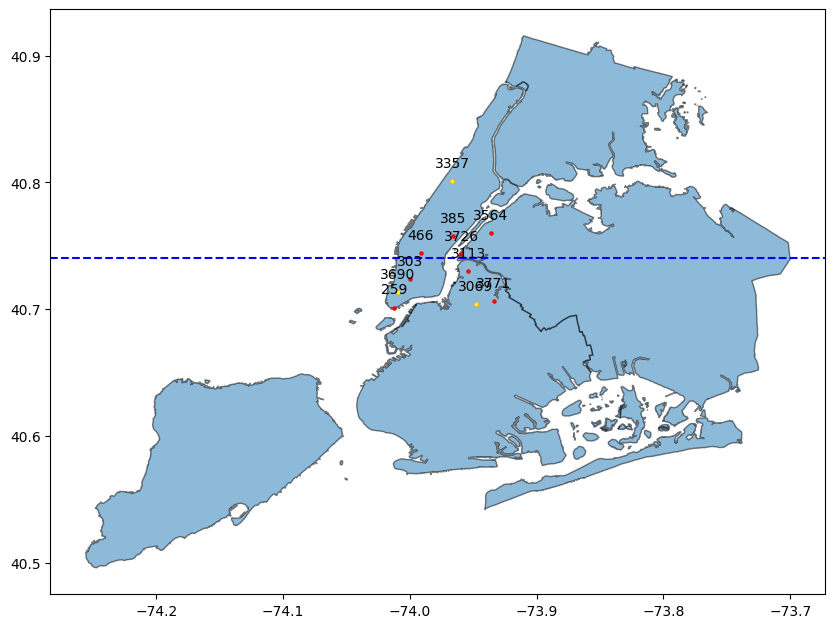

In [ ]:
from shapely.geometry import Point

gdf = gpd.GeoDataFrame(stations, geometry=gpd.points_from_xy(stations['lon'], stations['lat']))

# Plot the NYC map
manhattan.plot(figsize=(10, 10), alpha=0.5, edgecolor='k')

# Plot your data points on top of the map and add labels
ax = gdf.plot(marker='o', color='red', markersize=5, ax=plt.gca())

# Plot stations with station_id 3357 and 3069 in a yellow marker
gdf[gdf['station_id'].isin(['3357', '3069', '3690'])].plot(marker='o', color='yellow', markersize=5, ax=ax)

for x, y, label in zip(gdf.geometry.x, gdf.geometry.y, gdf.station_id):
    ax.annotate(label, (x, y), textcoords="offset points", xytext=(0, 10), ha='center')
    
# Draw a line at latitude 40.74
ax.axhline(y=40.74, color='blue', linestyle='--', label='Latitude 40.74')

# Show the plot
plt.show()

And what is the performance of the tree? Let's evaluate the model in the validation dataset.

In [ ]:
@component(
    base_image="gcr.io/deeplearning-platform-release/base-cpu.py310:latest",
    packages_to_install = ["scikit-learn==1.3.1"],
)
def evaluate(
    in_df_test: Input[Dataset], 
    label: str,
    in_model: Input[Model], 
    mult_stations: bool = True,
    stations: list = [],
    pick_features: list = None,
) -> float:

    import pandas as pd
    import joblib
    from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

    # 1. Read artifacts:
    df_test = pd.read_pickle(in_df_test.uri + ".pkl") 
    model = joblib.load(in_model.uri + '.joblib')

    # 2. Prepare dataset:
    y_test = df_test[label].copy()
    x_test = df_test.drop([label], axis=1)

    # 2. Preprocess categorical variables:
    # Staion:
    if mult_stations:
        for station in stations:
            x_test['station_id_'+station] = x_test.station_id == station
    # Year:    
    x_test['year_2020'] = x_test.year == 2020
    x_test['year_2021'] = x_test.year == 2021

    # Drop previous:
    x_test = x_test.drop(['station_id', 'true_bike_capacity', 'year'], axis=1)

    # Pick labels:
    if pick_features:
       x_test = x_test[pick_features]
        
    # 3. Make prediction:
    y_pred = model.predict(x_test)
    
    # Evaluate:
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    dict = {'rmse':rmse, 'mae':mae, 'r2':r2}
    return dict, y_pred

evaluate_func = evaluate.python_func

In [ ]:
dict_eval, y_pred = evaluate_func(
    in_df_test = art_df_val, 
    label = label_model,
    stations = stations_list, 
    in_model = art_dt, 
)
dict_eval

{'rmse': 0.27882235677688794,
 'mae': 0.2332919251679511,
 'r2': 0.2931607090236271}

Let's try with different set of parameters:

In [ ]:
def tree_train_eval(d,s):
    features = tree_prep_train_func(
        in_df_train = art_df_train,
        label = label_model,
        stations = stations_list, 
        out_dt = art_dt,
        max_depth = d,
        min_samples_leaf = s,
    )
    dict_eval, _ = evaluate_func(
        in_df_test = art_df_val, 
        label = label_model,
        stations = stations_list, 
        in_model = art_dt, 
    )
    return dict_eval

In [ ]:
scores = []

for d in [4,5,6,10,15,20,None]:
    for s in [1,2,5,10,15,20,100,200,500]:
        dict_eval = tree_train_eval(d=d, s=s)
        scores.append((d,s,dict_eval['rmse'], dict_eval['mae'], dict_eval['r2']))

columns = ['max_depth', 'min_samples_leaf', 'rmse', 'mae', 'r2']
df_scores = pd.DataFrame(scores, columns = columns)
df_scores.head()

,max_depth,min_samples_leaf,rmse,mae,r2
0,4.0,1,0.275036,0.224937,0.312229
1,4.0,2,0.275036,0.224937,0.312229
2,4.0,5,0.275036,0.224937,0.312229
3,4.0,10,0.275036,0.224937,0.312229
4,4.0,15,0.275036,0.224937,0.312229


In [ ]:
df_scores.sort_values(by = 'r2', ascending = False).head()

,max_depth,min_samples_leaf,rmse,mae,r2
6,4.0,100,0.275036,0.224937,0.312229
1,4.0,2,0.275036,0.224937,0.312229
8,4.0,500,0.275036,0.224937,0.312229
2,4.0,5,0.275036,0.224937,0.312229
5,4.0,20,0.275036,0.224937,0.312229


Let's try to see what happens if we use only the data for one of the stations we explored, in this case, the Flatiron station (where we saw the time of the day really affected bike availability).

## TRAIN: DECISION TREE (FLATIRON STATION)

In [ ]:
art_df_flat = Dataset(uri = '../data/data_prep_flat')
df_flat = pd.read_pickle(art_df_flat.uri+'.pkl')
df_flat.head()

,station_id,lat,lon,true_bike_capacity,capacity,percentage_bikes_available,dayofweek,weekend,dayofmonth,dayofyear,month,year,hour,minute,is_holiday
station_status_last_reported,,,,,,,,,,,,,,,
2020-11-30 19:00:00-05:00,466,40.743954,-73.991449,28,35,0.821429,0,0,30,335,11,2020,19,0,0
2020-11-30 19:05:00-05:00,466,40.743954,-73.991449,28,35,0.821429,0,0,30,335,11,2020,19,5,0
2020-11-30 19:10:00-05:00,466,40.743954,-73.991449,28,35,0.821429,0,0,30,335,11,2020,19,10,0
2020-11-30 19:15:00-05:00,466,40.743954,-73.991449,28,35,0.857143,0,0,30,335,11,2020,19,15,0
2020-11-30 19:20:00-05:00,466,40.743954,-73.991449,28,35,0.821429,0,0,30,335,11,2020,19,20,0


In [ ]:
df_flat.size

1576800

In [ ]:
split_data_func(
    in_df = art_df_flat,
    out_df_full_train = art_df_train_full, 
    out_df_test = art_df_test,
    out_df_train = art_df_train, 
    out_df_val = art_df_val,
)

In [ ]:
features = tree_prep_train_func(
    in_df_train = art_df_train,
    label = label_model,
    max_depth = 3,
    out_dt = art_dt,
    mult_stations = False,
    pick_features = ['dayofweek', 'dayofmonth','dayofyear','hour', 'minute', 'month', 'is_holiday','year_2020', 'year_2021'],
)

In [ ]:
dt_flat = joblib.load(art_dt.uri + '.joblib')
print(export_text(dt_flat, feature_names=features))

|--- hour <= 9.50
|   |--- dayofweek <= 4.50
|   |   |--- dayofweek <= 0.50
|   |   |   |--- value: [0.52]
|   |   |--- dayofweek >  0.50
|   |   |   |--- value: [0.33]
|   |--- dayofweek >  4.50
|   |   |--- dayofyear <= 188.00
|   |   |   |--- value: [0.54]
|   |   |--- dayofyear >  188.00
|   |   |   |--- value: [0.31]
|--- hour >  9.50
|   |--- hour <= 17.50
|   |   |--- dayofweek <= 3.50
|   |   |   |--- value: [0.62]
|   |   |--- dayofweek >  3.50
|   |   |   |--- value: [0.52]
|   |--- hour >  17.50
|   |   |--- dayofweek <= 3.50
|   |   |   |--- value: [0.36]
|   |   |--- dayofweek >  3.50
|   |   |   |--- value: [0.52]



We can observe hour of the day is indeed a feature that affects the bike availability for this station! Let's go through one branch. If we would like to know the bike availability: is it before or after 9:30 am? It's after 9:30? Then is it before or after 5:30 pm? Is it after? Is it Friday/Saturday/Sunday (dow >= 4)? Then the percentage of bikes available should be 52%.

But let's evaluate these predictions:

In [ ]:
# Train:
dict_eval, y_pred = evaluate_func(
    in_df_test = art_df_train, 
    label = label_model, 
    in_model = art_dt, 
    mult_stations = False,
    pick_features = ['dayofweek', 'dayofmonth','dayofyear','hour', 'minute', 'month', 'is_holiday','year_2020', 'year_2021'],
)
dict_eval

{'rmse': 0.2639418000299895,
 'mae': 0.22373139080102003,
 'r2': 0.1533462664489046}

In [ ]:
# Validation:
dict_eval, y_pred = evaluate_func(
    in_df_test = art_df_val, 
    label = label_model, 
    in_model = art_dt, 
    mult_stations = False,
    pick_features = ['dayofweek', 'dayofmonth','dayofyear','hour', 'minute', 'month', 'is_holiday','year_2020', 'year_2021'],
)
dict_eval

{'rmse': 0.27723924634017394,
 'mae': 0.23998466615518468,
 'r2': 0.17399246243916688}

In [ ]:
def tree_train_eval(d,s):
    features = tree_prep_train_func(
        in_df_train = art_df_train,
        label = label_model,
        max_depth = d,
        min_samples_leaf = s,
        out_dt = art_dt,
        mult_stations = False,
        pick_features = ['dayofweek', 'dayofmonth','dayofyear','hour', 'minute', 'month', 'is_holiday','year_2020', 'year_2021'],
    )
    dict_eval, _ = evaluate_func(
        in_df_test = art_df_val, 
        label = label_model, 
        in_model = art_dt, 
        mult_stations = False,
        pick_features = ['dayofweek', 'dayofmonth','dayofyear','hour', 'minute', 'month', 'is_holiday','year_2020', 'year_2021'],
    )
    return dict_eval

In [ ]:
scores = []

for d in [4,5,6,10,15,20,None]:
    for s in [1,2,5,10,15,20,100,200,500]:
        dict_eval = tree_train_eval(d=d, s=s)
        scores.append((d,s,dict_eval['rmse'], dict_eval['mae'], dict_eval['r2']))

columns = ['max_depth', 'min_samples_leaf', 'rmse', 'mae', 'r2']
df_scores = pd.DataFrame(scores, columns = columns)

In [ ]:
df_scores.sort_values(by = 'mae', ascending = True).head()

,max_depth,min_samples_leaf,rmse,mae,r2
17,5.0,500,0.291125,0.231974,0.089177
10,5.0,2,0.297655,0.233799,0.047858
9,5.0,1,0.297655,0.233799,0.047858
14,5.0,20,0.297655,0.233799,0.047858
12,5.0,10,0.297655,0.233799,0.047858


We see the same poor performance, we will try with a more complex model (xgboost).

## TRAIN: XGBOOST

In [ ]:
split_data_func(
    in_df = art_df,
    out_df_full_train = art_df_train_full, 
    out_df_test = art_df_test,
    out_df_train = art_df_train, 
    out_df_val = art_df_val,
)

In [ ]:
@component(
    base_image="gcr.io/deeplearning-platform-release/base-cpu.py310:latest",
    packages_to_install = [
        "scikit-learn==1.3.1",
        "xgboost==2.0.0",
    ],
)
def xgb_train(
    in_df_train: Input[Dataset],
    in_df_val: Input[Dataset],
    
    label: str,
    
    out_xgb_model: Output[Model],
    
    eta: float = 0.3,    
    max_depth: int = 6,
    min_child_weight: int = 1,

    objective: str = 'reg:squarederror',
    eval_metric: str = 'mae',
    
    n_jobs: int = 8,
    seed: int = 1, 
    verbosity: int = 1, # 0 (silent) - 3 (debug).

    early_stopping_rounds: int = 100,
    verbose_early: bool = False,

    mult_stations: bool = True,
    stations: list = [],
    pick_features: list = None,

    params: dict = None,
    n_iter: int = 200,
    verbose_cv: int = 1, 
    return_train_score: bool = True,
    cv: int=3,
):
    import pandas as pd 
    import numpy as np

    import joblib
    import pickle

    from sklearn.model_selection import GridSearchCV
    
    import xgboost as xgb

    df_train = pd.read_pickle(in_df_train.uri + ".pkl") 
    df_val = pd.read_pickle(in_df_val.uri + ".pkl")

    y_train = df_train[label].copy()
    y_val = df_val[label].copy()

    x_train = df_train.drop([label], axis=1)
    x_val = df_val.drop([label], axis=1)

    # Preprocess categorical variables:
    # Staion:
    if mult_stations:
        for station in stations:
            x_train['station_id_'+station] = x_train.station_id == station
            x_val['station_id_'+station] = x_val.station_id == station
    # Year:    
    x_train['year_2020'] = x_train.year == 2020
    x_val['year_2020'] = x_val.year == 2020
    
    x_train['year_2021'] = x_train.year == 2021
    x_val['year_2021'] = x_val.year == 2021

    # Drop previous:
    x_train = x_train.drop(['station_id', 'true_bike_capacity', 'year'], axis=1)
    x_val = x_val.drop(['station_id', 'true_bike_capacity', 'year'], axis=1)

    # Pick labels:
    if pick_features:
        x_train = x_train[pick_features] 
        x_val = x_val[pick_features] 
    
    features = x_train.columns.to_list()

    xgb_model = xgb.XGBRegressor(
        eta = eta,
        max_depth = max_depth,
        min_child_weight = min_child_weight,
        
        objective = objective,
        eval_metric = eval_metric,
        
        n_jobs = n_jobs,
        seed = seed,
        verbosity = verbosity,
    )

    if params:
        search = GridSearchCV(
            xgb_model, 
            param_grid=params, 
            #random_state=seed, 
            #n_iter=n_iter, 
            cv=cv, 
            verbose=verbose_cv, 
            n_jobs=n_jobs, 
            return_train_score=return_train_score,
            scoring = 'roc_auc',
        )
        search.fit(x_train, y_train)
        search_results = search.cv_results_
        eval_results = None
    else:
        xgb_model.fit(
            x_train, 
            y_train,
            early_stopping_rounds=early_stopping_rounds, 
            eval_set=[(x_train, y_train),(x_val, y_val)],
            verbose=verbose_early,
        )

        eval_results = xgb_model.evals_result()
        search_results = None

    with open(out_xgb_model.uri+'.joblib', 'wb') as f:
        pickle.dump(xgb_model, f)

    return eval_results, search_results

xgb_train_func = xgb_train.python_func

In [ ]:
art_xgb_model = Model(uri = artifacts_uri +'xgb_model')

eval_results, _ = xgb_train_func(
    in_df_train = art_df_train,
    in_df_val = art_df_val,

    label = label_model,
    objective='reg:logistic',
    eta=.1,
    max_depth = 3,
    early_stopping_rounds= 400,

    out_xgb_model = art_xgb_model,

    stations = stations_list,
)

In [ ]:
train_mae = list(eval_results['validation_0'].values())[0]
val_mae = list(eval_results['validation_1'].values())[0]
num_iter = range(len(val_mae))

<matplotlib.legend.Legend>

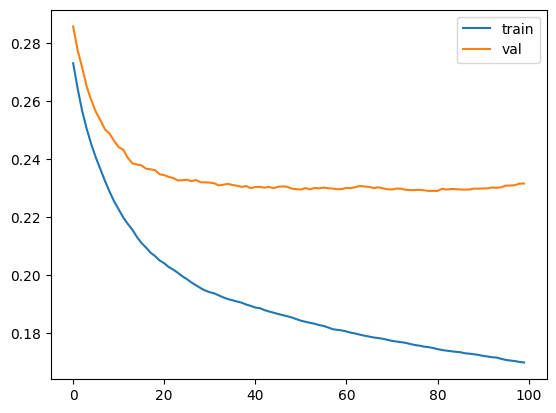

In [ ]:
plt.plot(num_iter, train_mae, label='train')
plt.plot(num_iter, val_mae, label='val')
plt.legend()

In [ ]:
val_mae[-1]

0.23162499619866714

## EXPORTING FINAL MODEL

We will train a final model with our original Decision Tree architecture (there was not a great improvement using a complex model and we could use further explainability for model enhancements):

In [ ]:
split_data_func(
    in_df = art_df,
    out_df_full_train = art_df_train_full, 
    out_df_test = art_df_test,
    out_df_train = art_df_train, 
    out_df_val = art_df_val,
)

In [ ]:
art_model = Model(uri = artifacts_uri +'model')

features = tree_prep_train_func(
    in_df_train = art_df_train_full,
    label = label_model,
    stations = stations_list, 
    max_depth = 5, # Chosen with parameter tuning
    min_samples_leaf=500, # Chosen with parameter tuning
    out_dt = art_model,
)

In [ ]:
model = joblib.load(art_model.uri + '.joblib')
print(export_text(model, feature_names=features))

|--- lat <= 40.74
|   |--- station_id_3069 <= 0.50
|   |   |--- station_id_3690 <= 0.50
|   |   |   |--- hour <= 8.50
|   |   |   |   |--- dayofyear <= 156.50
|   |   |   |   |   |--- value: [0.72]
|   |   |   |   |--- dayofyear >  156.50
|   |   |   |   |   |--- value: [0.64]
|   |   |   |--- hour >  8.50
|   |   |   |   |--- dayofyear <= 72.50
|   |   |   |   |   |--- value: [0.68]
|   |   |   |   |--- dayofyear >  72.50
|   |   |   |   |   |--- value: [0.76]
|   |   |--- station_id_3690 >  0.50
|   |   |   |--- dayofyear <= 59.50
|   |   |   |   |--- dayofyear <= 18.50
|   |   |   |   |   |--- value: [0.39]
|   |   |   |   |--- dayofyear >  18.50
|   |   |   |   |   |--- value: [0.18]
|   |   |   |--- dayofyear >  59.50
|   |   |   |   |--- dayofyear <= 161.50
|   |   |   |   |   |--- value: [0.75]
|   |   |   |   |--- dayofyear >  161.50
|   |   |   |   |   |--- value: [0.44]
|   |--- station_id_3069 >  0.50
|   |   |--- dayofyear <= 76.50
|   |   |   |--- dayofyear <= 67.50
|   | 

In [ ]:
dict_eval, y_pred = evaluate_func(
    in_df_test = art_df_test, 
    label = label_model,
    stations = stations_list, 
    in_model = art_model, 
)
dict_eval

{'rmse': 0.2818314272967605,
 'mae': 0.23052204824573058,
 'r2': 0.2998922347616616}